In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

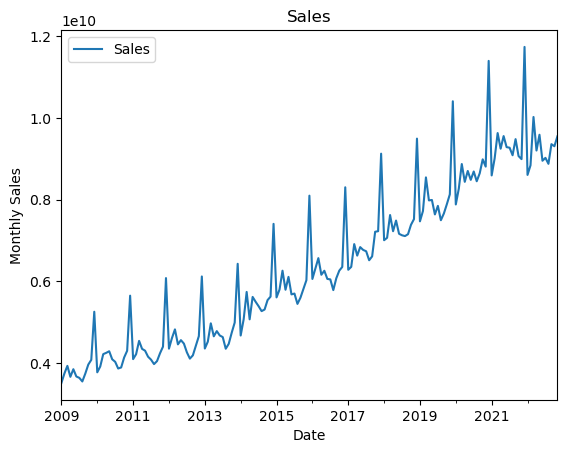

In [3]:
# pandasを使う
df = pd.read_csv("../public/seijyo_ishii_monthly_sales.csv", index_col='Month', parse_dates=True)
df.plot()
plt.title('Sales')
plt.ylabel('Monthly Sales')
plt.xlabel('Date')
plt.show()

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


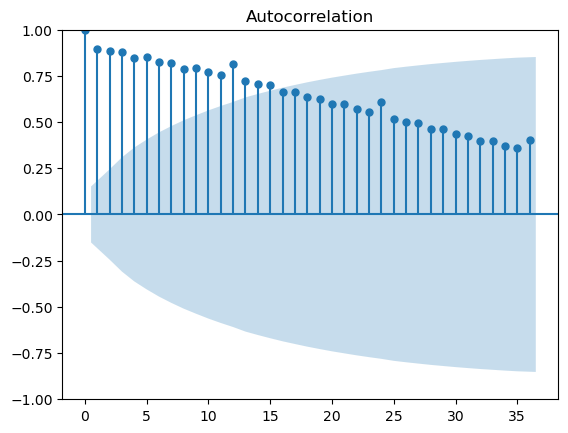

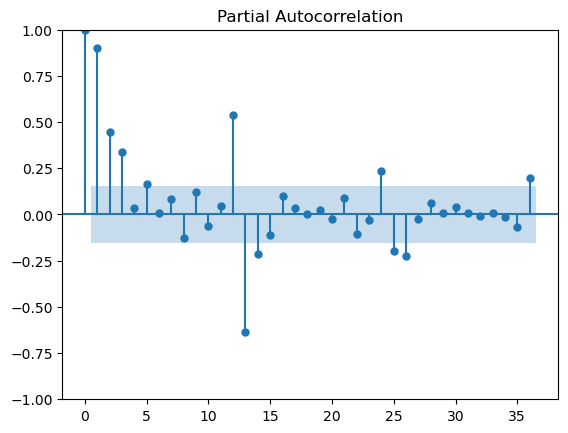

In [4]:
# コレログラム（自己相関と偏自己相関）
data = df.dropna()
utils.plot_acf(data, alpha=.05, lags=36)
utils.plot_pacf(data, alpha=.05, lags=36)

# 水色になっている部分は95%信頼区間を示す。
# 信頼区間外にデータが及ぶ点は統計的に有意差がある。

In [5]:
# 自己相関グラフから横軸が12,24,36の時に大きくなり、12ヶ月ごとの周期性がある。
# 偏自己相関グラフではラグ1で大きな正の相関、ラグ13で大きな負の相関。

In [6]:
# 前半120時点を学習用データとして、残りを検証用データとする。
df_train = df[:120]
df_test = df[120:156]

In [7]:
# 前半の120時点のデータに対してADF検定をして、定常過程であるかどうか確認する。

from statsmodels.tsa import stattools

# トレンド項あり(2次まで)，定数項ありの場合
ctt = stattools.adfuller(df_train, regression="ctt")
# トレンド項あり(1次)，定数項ありの場合
ct = stattools.adfuller(df_train, regression="ct")
# トレンド項なし，定数項ありの場合
c = stattools.adfuller(df_train, regression="c")
# トレンド項なし，定数項なしの場合
nc = stattools.adfuller(df_train, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-2.623004075781371, 0.4984856891359786, 13, 106, {'1%': -4.48392099206056, '5%': -3.8893150700242485, '10%': -3.5883089687795966}, 4310.044960757604)
ct:
(-1.8025624166133445, 0.7035214404941403, 13, 106, {'1%': -4.0468193247781725, '5%': -3.452751165593073, '10%': -3.151810567112449}, 4312.515717918262)
c:
(0.6280055262731989, 0.9882859561128791, 13, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 4315.049557278324)
nc:
(2.290172718233122, 0.996003981694231, 13, 106, {'1%': -2.5871552545389815, '5%': -1.9438072306333416, '10%': -1.6145345885529665}, 4313.1094992607295)


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [8]:
# p値(タプル値の2番目の要素)が4パターン全てで5%を超えているため、帰無仮説を棄却できず、データに定常性はない。

<AxesSubplot:xlabel='Month'>

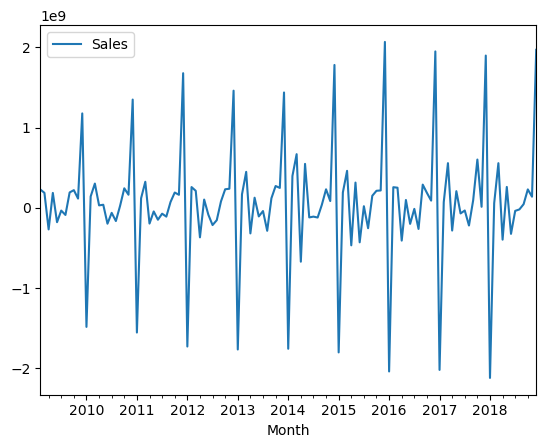

In [9]:
# 1次階差をとって、定常過程に変換する

df_diff = df.diff()[:120].dropna()
df_diff.plot()

In [10]:
ctt = stattools.adfuller(df_diff, regression="ctt")
ct = stattools.adfuller(df_diff, regression="ct")
c = stattools.adfuller(df_diff, regression="c")
nc = stattools.adfuller(df_diff, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-2.693013930668132, 0.45828635891818287, 12, 106, {'1%': -4.48392099206056, '5%': -3.8893150700242485, '10%': -3.5883089687795966}, 4276.199111291289)
ct:
(-2.6955076463573815, 0.2379525598448642, 12, 106, {'1%': -4.0468193247781725, '5%': -3.452751165593073, '10%': -3.151810567112449}, 4274.673742260313)
c:
(-2.51151111605336, 0.1126986087783019, 12, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 4274.0114493249275)
nc:
(-1.1739349859911308, 0.21949105289436593, 12, 106, {'1%': -2.5871552545389815, '5%': -1.9438072306333416, '10%': -1.6145345885529665}, 4277.257567504737)


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [11]:
# 1次階差でも、p値が4パターン全てで5%を超えているため、データに定常性はない。

<AxesSubplot:xlabel='Month'>

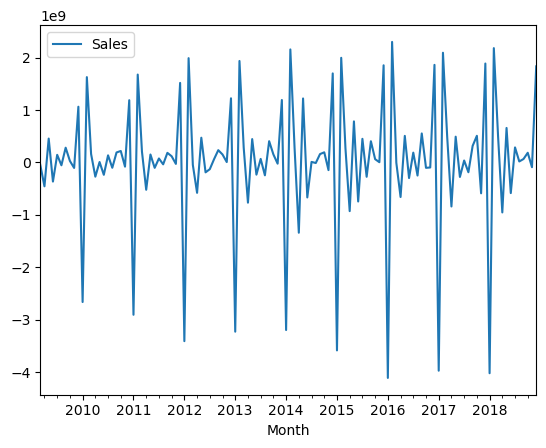

In [12]:
# 2次階差をとって、定常過程に変換する

df_diff2 = df_diff.diff().dropna()
df_diff2.plot()

In [13]:
ctt = stattools.adfuller(df_diff2, regression="ctt")
ct = stattools.adfuller(df_diff2, regression="ct")
c = stattools.adfuller(df_diff2, regression="c")
nc = stattools.adfuller(df_diff2, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-11.563436995641615, 1.4519777910938497e-18, 11, 106, {'1%': -4.48392099206056, '5%': -3.8893150700242485, '10%': -3.5883089687795966}, 4236.85940939745)
ct:
(-11.613277807454521, 1.7071494079118423e-18, 11, 106, {'1%': -4.0468193247781725, '5%': -3.452751165593073, '10%': -3.151810567112449}, 4236.212997419323)
c:
(-11.66552985641674, 1.8882348611152833e-21, 11, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 4234.221353375455)
nc:
(-11.729618848210677, 2.397282517869159e-21, 11, 106, {'1%': -2.5871552545389815, '5%': -1.9438072306333416, '10%': -1.6145345885529665}, 4232.252576939924)


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [14]:
# p値は大幅に改善したが、一旦差分変換はやめて、対数変換を取る。

<AxesSubplot:xlabel='Month'>

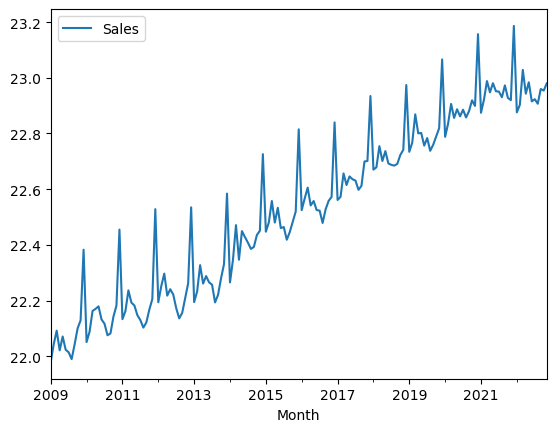

In [15]:
# 対数変換
df_log = np.log(df).dropna()
# 系列のプロット
df_log.plot()

In [16]:
ctt = stattools.adfuller(df_log, regression="ctt")
ct = stattools.adfuller(df_log, regression="ct")
c = stattools.adfuller(df_log, regression="c")
nc = stattools.adfuller(df_log, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-2.4779216879573696, 0.5819601582186784, 14, 152, {'1%': -4.449013616587239, '5%': -3.871817570299971, '10%': -3.5775835089731554}, -652.3239616299179)
ct:
(-2.7943750976902337, 0.19901808742007288, 14, 152, {'1%': -4.019598505829475, '5%': -3.4397782320445764, '10%': -3.1442367831043154}, -654.1925295177296)
c:
(-0.6386770233486408, 0.8620009661843229, 13, 153, {'1%': -3.473829775724492, '5%': -2.880622899711496, '10%': -2.5769448985432954}, -648.823063875376)
nc:
(2.906672669002065, 0.9996866573853719, 13, 153, {'1%': -2.5805080123029605, '5%': -1.9428905860183936, '10%': -1.6151929088052552}, -650.3452111724355)


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [17]:
# 分散
df_log.var()

Sales    0.09728
dtype: float64

In [37]:
df.var()

Sales    3.886751e+18
dtype: float64

In [18]:
# 分散がかなり0に近づいており、データのばらつきが解消され、定常過程に近づいた。

In [19]:
# 対数差分変換をする。

<AxesSubplot:xlabel='Month'>

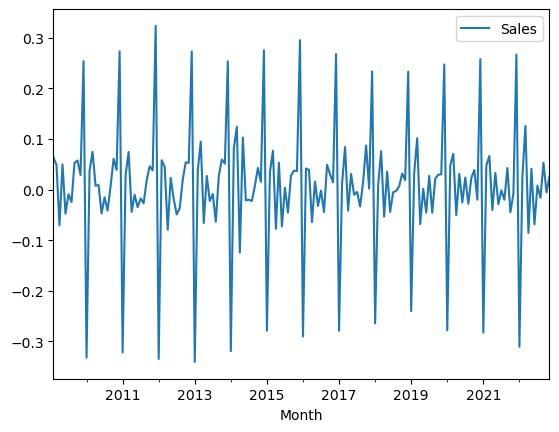

In [20]:
# 対数差分変換
df_log_diff = df_log.diff().dropna()
# 系列のプロット
df_log_diff.plot()

In [21]:
ctt = stattools.adfuller(df_log_diff, regression="ctt")
ct = stattools.adfuller(df_log_diff, regression="ct")
c = stattools.adfuller(df_log_diff, regression="c")
nc = stattools.adfuller(df_log_diff, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-3.6414466057267663, 0.08121984462485515, 12, 153, {'1%': -4.448493275395168, '5%': -3.871555927550909, '10%': -3.5774228099577363}, -656.7621905305887)
ct:
(-3.405204215687586, 0.050696483074815224, 12, 153, {'1%': -4.019192449915219, '5%': -3.439584098940215, '10%': -3.144123265603392}, -654.1402949471756)
c:
(-3.39155402818739, 0.011250186038315235, 12, 153, {'1%': -3.473829775724492, '5%': -2.880622899711496, '10%': -2.5769448985432954}, -656.1353606439459)
nc:
(-1.4841786224480331, 0.12899923025355553, 13, 152, {'1%': -2.5806061963296396, '5%': -1.9429038601768662, '10%': -1.615182877924989}, -650.2720984307273)


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [22]:
# p値は大幅に減少できたが、まだ少し5%を超えているため、帰無仮説を棄却できない。(残念)

In [23]:
# もう一度差分を取ってみる。

<AxesSubplot:xlabel='Month'>

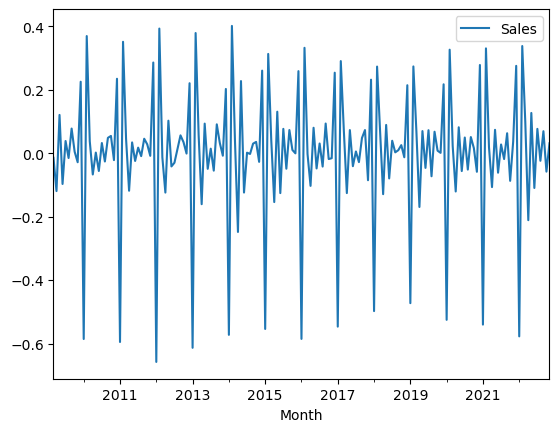

In [24]:
# 対数差分変換
df_log_diff2 = df_log_diff.diff().dropna()
# 系列のプロット
df_log_diff2.plot()

In [25]:
ctt = stattools.adfuller(df_log_diff2, regression="ctt")
ct = stattools.adfuller(df_log_diff2, regression="ct")
c = stattools.adfuller(df_log_diff2, regression="c")
nc = stattools.adfuller(df_log_diff2, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-10.048615718264834, 3.5011438434525657e-15, 12, 152, {'1%': -4.449013616587239, '5%': -3.871817570299971, '10%': -3.5775835089731554}, -638.3817830463443)
ct:
(-10.097538766087295, 1.4363662948327116e-15, 12, 152, {'1%': -4.019598505829475, '5%': -3.4397782320445764, '10%': -3.1442367831043154}, -640.086932383535)
c:
(-10.136865953847938, 8.623478054571877e-18, 12, 152, {'1%': -3.474120870218417, '5%': -2.880749791423677, '10%': -2.5770126333102494}, -642.0507181730134)
nc:
(-10.175387588480344, 4.123286735998897e-18, 12, 152, {'1%': -2.5806061963296396, '5%': -1.9429038601768662, '10%': -1.615182877924989}, -643.9711258143864)


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [26]:
# 2回差分を取るとp値がほぼ0となり定常過程と言えるようになった。
# しかし2回差分を取っているサイトはあまりないので、このまま検討を進めて良いか微妙。

In [27]:
# ここまで以下のサイトを参考にした。
# https://qiita.com/tk-tatsuro/items/16ce74fc954b5a58df00

In [28]:
# メモ
# 定常過程：時間が経過してもデータを生成する確率分布が変化しない系列
# 単位根過程：1次の差分を取った階差系列が定常過程に従う系列
# 和分過程：任意のd次階差系列系が定常過程になる系列
# 参照サイト：https://www.lifull.blog/entry/2019/12/25/151030#%E3%83%9E%E3%83%BC%E3%82%B1%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90%E3%81%AE%E6%B4%BB%E7%94%A8%E6%A9%9F%E4%BC%9A

In [29]:
df_log_train = df_log[:120]
df_log_test = df_log[120:156]

In [30]:
# pmdarimaのauto_arima関数を使って、ARIMAモデルを自動構築する。

arima_model = pm.auto_arima(df_log_train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-456.959, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-157.171, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-300.773, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-158.622, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-300.621, Time=0.11 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-450.683, Time=0.29 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-450.372, Time=0.44 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-449.126, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-202.900, Time=0.11 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-348.126, Time=0.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-458.882, Time=0.45 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-459.961, Time=0.20 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-451.162, Time=0.13 sec
 ARIMA(1,1,2)(2,0,1)[12]

In [31]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_log_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('MAPE:')
print(mean_absolute_percentage_error(df_log_test, test_pred))

MAPE:
0.001993548131013052


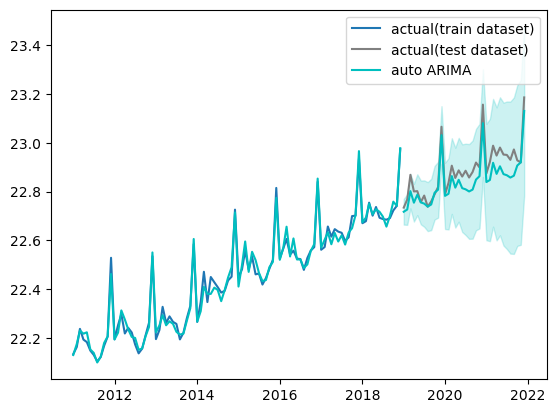

In [32]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_log_train[24:].index, df_log_train[24:].values, label="actual(train dataset)")
ax.plot(df_log_test.index, df_log_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_log_train[24:].index, train_pred[24:], color="c")
ax.plot(df_log_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_log_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

In [34]:
# 元系列に戻してMAPEを計算
print('MAPE:')
print(mean_absolute_percentage_error(df_test, np.exp(test_pred)))

MAPE:
0.04429248442856059


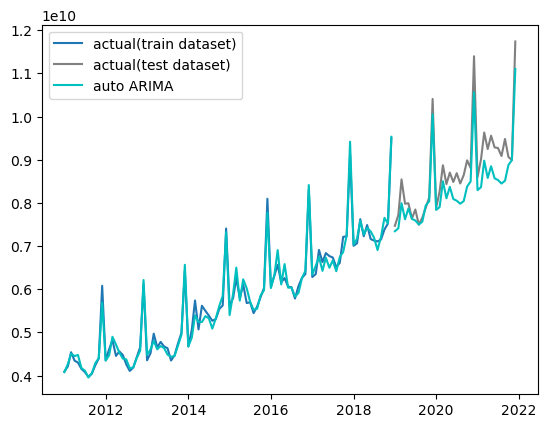

In [36]:
# 元系列のグラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, np.exp(train_pred[24:]), color="c")
ax.plot(df_test.index, np.exp(test_pred), label="auto ARIMA", color="c") 
ax.legend()